In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
historical_temps = pd.read_csv('../fully_connected_nn/preds_1880-1960_OUTSIDE.csv')
# this is the file we created by running our `fully_connected_1960.ipynb` on data observations in the range 1880 - 1960
historical_temps = historical_temps.drop('Unnamed: 0', axis=1)
historical_temps

,year,temp_anom,pred
0,1880,-0.580696,-0.301994
1,1881,-0.437284,-0.304912
2,1882,-0.448660,-0.292852
3,1883,-0.535872,-0.288944
4,1884,-0.577859,-0.279507
...,...,...,...
75,1955,-0.628892,0.326655
76,1956,-0.655931,0.332992
77,1957,-0.272213,0.338390
78,1958,-0.251039,0.346113


We will run an RNN for both the NOAA `temp_anom`s and our own predicted `pred` temperature anomalies. Then, we will see how similar/different those predictions are.

In [5]:
# flip the arrays so that they're goin in reverse order, and will thus predict the past rather than the future
coral_temp_anoms = np.flip(np.array(historical_temps['pred']), axis=None)
noaa_temp_anoms = np.flip(np.asarray(historical_temps['temp_anom']))
coral_temp_anoms[:5], noaa_temp_anoms[:5]

(array([0.35283712, 0.34611344, 0.33838984, 0.33299208, 0.32665533]),
 array([-0.22745812, -0.25103928, -0.27221271, -0.65593149, -0.62889203]))

In [6]:
len(coral_temp_anoms), len(noaa_temp_anoms)

(80, 80)

Predict the next annual temp anomaly based off of the previous 4.

In [15]:
N = 80  # total unmber of records
Tp = 65 # train on 65 records, test on 15

In [16]:
coral_train, coral_test = coral_temp_anoms[0:Tp], coral_temp_anoms[Tp:N]
noaa_train, noaa_test = noaa_temp_anoms[0:Tp], noaa_temp_anoms[Tp:N]

In [17]:
len(coral_train), len(coral_test)

(65, 15)

In [18]:
# predict the current year based on the past 4 years
step = 4
# add step elements into train and test
coral_test = np.append(coral_test,np.repeat(coral_test[-1,],step))
coral_train = np.append(coral_train,np.repeat(coral_train[-1,],step))

noaa_test = np.append(noaa_test,np.repeat(noaa_test[-1,],step))
noaa_train = np.append(noaa_train,np.repeat(noaa_train[-1,],step))

In [19]:
# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

coral_trainX, coral_trainY = convertToMatrix(coral_train,step)
coral_testX, coral_testY = convertToMatrix(coral_test,step)

noaa_trainX, noaa_trainY = convertToMatrix(noaa_train,step)
noaa_testX, noaa_testY = convertToMatrix(noaa_test,step)

In [20]:
coral_trainX = np.reshape(coral_trainX, (coral_trainX.shape[0], 1, coral_trainX.shape[1]))
coral_testX = np.reshape(coral_testX, (coral_testX.shape[0], 1, coral_testX.shape[1]))
coral_testX.shape

(15, 1, 4)

In [21]:
noaa_trainX = np.reshape(noaa_trainX, (noaa_trainX.shape[0], 1, noaa_trainX.shape[1]))
noaa_testX = np.reshape(noaa_testX, (noaa_testX.shape[0], 1, noaa_testX.shape[1]))
noaa_testX.shape

(15, 1, 4)

In [22]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

In [23]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1184      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(coral_trainX,coral_trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(coral_trainX)
testPredict= model.predict(coral_testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

Epoch 1/100
5/5 - 1s - loss: 0.0194
Epoch 2/100
5/5 - 0s - loss: 0.0128
Epoch 3/100
5/5 - 0s - loss: 0.0108
Epoch 4/100
5/5 - 0s - loss: 0.0090
Epoch 5/100
5/5 - 0s - loss: 0.0078
Epoch 6/100
5/5 - 0s - loss: 0.0068
Epoch 7/100
5/5 - 0s - loss: 0.0062
Epoch 8/100
5/5 - 0s - loss: 0.0055
Epoch 9/100
5/5 - 0s - loss: 0.0050
Epoch 10/100
5/5 - 0s - loss: 0.0044
Epoch 11/100
5/5 - 0s - loss: 0.0036
Epoch 12/100
5/5 - 0s - loss: 0.0032
Epoch 13/100
5/5 - 0s - loss: 0.0028
Epoch 14/100
5/5 - 0s - loss: 0.0024
Epoch 15/100
5/5 - 0s - loss: 0.0021
Epoch 16/100
5/5 - 0s - loss: 0.0018
Epoch 17/100
5/5 - 0s - loss: 0.0015
Epoch 18/100
5/5 - 0s - loss: 0.0012
Epoch 19/100
5/5 - 0s - loss: 8.4907e-04
Epoch 20/100
5/5 - 0s - loss: 6.7414e-04
Epoch 21/100
5/5 - 0s - loss: 5.9649e-04
Epoch 22/100
5/5 - 0s - loss: 5.0399e-04
Epoch 23/100
5/5 - 0s - loss: 4.5523e-04
Epoch 24/100
5/5 - 0s - loss: 3.7165e-04
Epoch 25/100
5/5 - 0s - loss: 2.6910e-04
Epoch 26/100
5/5 - 0s - loss: 2.1959e-04
Epoch 27/100
5/

In [25]:
#Next, we'll check the loss
trainScore = model.evaluate(coral_trainX, coral_trainY, verbose=0)
print(trainScore)

1.2596336091519333e-05


In [26]:
# put them in the right order again
predicted = np.flip(predicted)

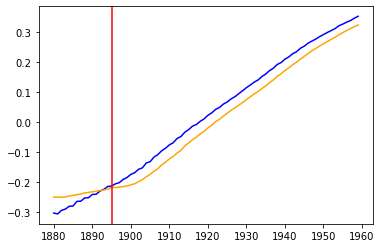

In [38]:
# Finally, we check the result in a plot. 
index = historical_temps['year'].values
plt.plot(index,historical_temps['pred'], color = 'blue')
#plt.plot(index,historical_temps['temp_anom'], color = 'green')
plt.plot(index,predicted, color="orange")
# A vertical line in a plot identifies a splitting point between the training and the test part.
plt.axvline(historical_temps['year'][N - Tp], c="r")
plt.title('RNN Applied to Predicted Temperature Data from Fully-Connected Model\n\nRNN Model was run backwards (1960 --> 1880)\nRed Line = Start of Test Data (1895 - 1880)')
plt.ylabel('Temp Anom')
plt.show() 

In [29]:
model.fit(noaa_trainX,noaa_trainY, epochs=100, batch_size=16, verbose=2)
trainPredict_noaa = model.predict(noaa_trainX)
testPredict_noaa= model.predict(noaa_testX)
predicted_noaa=np.concatenate((trainPredict_noaa,testPredict_noaa),axis=0)

Epoch 1/100
5/5 - 0s - loss: 0.0487
Epoch 2/100
5/5 - 0s - loss: 0.0367
Epoch 3/100
5/5 - 0s - loss: 0.0341
Epoch 4/100
5/5 - 0s - loss: 0.0304
Epoch 5/100
5/5 - 0s - loss: 0.0287
Epoch 6/100
5/5 - 0s - loss: 0.0280
Epoch 7/100
5/5 - 0s - loss: 0.0272
Epoch 8/100
5/5 - 0s - loss: 0.0271
Epoch 9/100
5/5 - 0s - loss: 0.0266
Epoch 10/100
5/5 - 0s - loss: 0.0263
Epoch 11/100
5/5 - 0s - loss: 0.0264
Epoch 12/100
5/5 - 0s - loss: 0.0258
Epoch 13/100
5/5 - 0s - loss: 0.0260
Epoch 14/100
5/5 - 0s - loss: 0.0258
Epoch 15/100
5/5 - 0s - loss: 0.0263
Epoch 16/100
5/5 - 0s - loss: 0.0253
Epoch 17/100
5/5 - 0s - loss: 0.0249
Epoch 18/100
5/5 - 0s - loss: 0.0245
Epoch 19/100
5/5 - 0s - loss: 0.0243
Epoch 20/100
5/5 - 0s - loss: 0.0242
Epoch 21/100
5/5 - 0s - loss: 0.0236
Epoch 22/100
5/5 - 0s - loss: 0.0236
Epoch 23/100
5/5 - 0s - loss: 0.0229
Epoch 24/100
5/5 - 0s - loss: 0.0230
Epoch 25/100
5/5 - 0s - loss: 0.0224
Epoch 26/100
5/5 - 0s - loss: 0.0222
Epoch 27/100
5/5 - 0s - loss: 0.0224
Epoch 28/1

In [31]:
#Next, we'll check the loss
trainScore = model.evaluate(noaa_trainX, noaa_trainY, verbose=0)
print(trainScore)

0.016928454861044884


In [32]:
# put them in the right order again
predicted_noaa = np.flip(predicted_noaa)

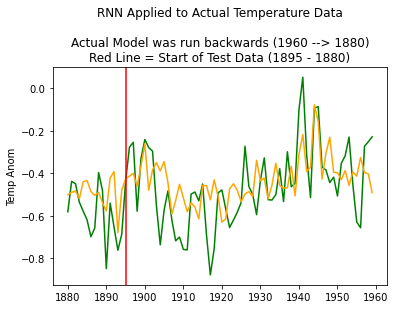

In [47]:
# Finally, we check the result in a plot. 
index = historical_temps['year'].values
#plt.plot(index,historical_temps['pred'], color = 'blue')
plt.plot(index,historical_temps['temp_anom'], color = 'green')
plt.plot(index,predicted_noaa, color="orange")
# A vertical line in a plot identifies a splitting point between the training and the test part.
plt.axvline(historical_temps['year'][N - Tp], c="r")
plt.title('RNN Applied to Actual Temperature Data\n\nActual Model was run backwards (1960 --> 1880)\nRed Line = Start of Test Data (1895 - 1880)')
plt.ylabel('Temp Anom')
plt.show() 